# Parcours Ingénieur Machine Learning


## Projet 5 : Catégorisez automatiquement des questions

## Partie 1 : Exploration et nettoyage des données

## Table des matières:
* [1. Préparation et chargement des fichiers](#1)
* [2. Nettoyage des données](#2)
    * [2.1 Fonctions de nettoyage](#2.1)
    * [2.2 Analyse, cleansing et sélection de "Tags"](#2.2)
    * [2.3 Analyse et cleansing de "Title"](#2.3)
    * [2.4 Analyse et cleansing de "Body"](#2.4)
    * [2.5 Suppression des mots peu fréquents](#2.5)
* [Export des données](#3)

## 1. Préparation et chargement des fichiers<a class="anchor" id="1"></a>

In [1]:
#import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

#options
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', -1)

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Création du dataframe
df = pd.DataFrame(columns=["Id", "Title", "Body", "Tags"])

# Alimentation du dataframe
#file_name = 'query{}.csv'
#df = pd.concat([pd.read_csv(file_name.format(i)) for i in range(1, 4)])

df = pd.read_csv('QueryResults.csv')

In [3]:
display(df.head())

,Id,Title,Body,Tags
0,10564,How can I set up an editor to work with Git on Windows?,"<p>I'm trying out <strong>Git on Windows</strong>. I got to the point of trying ""git commit"" and I got this error:</p>\n\n<blockquote>\n <p>Terminal is dumb but no VISUAL nor\n EDITOR defined. Please supply the\n message using either -m or -F option.</p>\n</blockquote>\n\n<p>So I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got <a href=""http://notepad-plus.sourceforge.net/uk/site.htm"" rel=""noreferrer"">Notepad++</a>, but I can't figure out how to get Notepad++ set up as the <code>%EDITOR%</code> in such a way that it works with Git as expected.</p>\n\n<p>I'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to <strong>type commit messages in an editor</strong> rather than the command line (with <code>-m</code>).</p>\n\n<p>Those of you using Git on Windows: What tool do you use to edit your commit messages, and what did you have to do to make it work?</p>\n",<windows><git><cygwin><editor>
1,19132,Expression Versus Statement,"<p>I'm asking with regards to c#, but I assume its the same in most other languages.</p>\n\n<p>Does anyone have a good definition of <em>expressions</em> and <em>statements</em> and what the differences are?</p>\n",<language-agnostic><expression><language-features>
2,19254029,AngularJs $http.post() does not send data,"<p>Could anyone tell me why the following statement does not send the post data to the designated url? The url is called but on the server when I print $_POST - I get an empty array. If I print message in the console before adding it to the data - it shows the correct content.</p>\n\n<pre><code>$http.post('request-url', { 'message' : message });\n</code></pre>\n\n<p>I've also tried it with the data as string (with the same outcome):</p>\n\n<pre><code>$http.post('request-url', ""message="" + message);\n</code></pre>\n\n<p>It seem to be working when I use it in the following format:</p>\n\n<pre><code>$http({\n method: 'POST',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'Content-Type': 'application/x-www-form-urlencoded'}\n});\n</code></pre>\n\n<p>but is there a way of doing it with the $http.post() - and do I always have to include the header in order for it to work? I believe that the above content type is specifying format of the sent data, but can I send it as javascript object?</p>\n",<angularjs><post><angular-http>
3,19147,What is the correct way to create a single-instance WPF application?,"<p>Using C# and WPF under .NET (rather than <a href=""http://en.wikipedia.org/wiki/Windows_Forms"" rel=""noreferrer"">Windows Forms</a> or console), what is the correct way to create an application that can only be run as a single instance?</p>\n\n<p>I know it has something to do with some mythical thing called a mutex, rarely can I find someone that bothers to stop and explain what one of these are.</p>\n\n<p>The code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.</p>\n",<c#><.net><wpf><mutex>
4,19151,Build a Basic Python Iterator,<p>How would one create an iterative function (or iterator object) in python?</p>\n,<python><object><iterator>


In [4]:
display(df.shape)

(20483, 4)

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20483 entries, 0 to 20482
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      20483 non-null  int64 
 1   Title   20483 non-null  object
 2   Body    20483 non-null  object
 3   Tags    20483 non-null  object
dtypes: int64(1), object(3)
memory usage: 640.2+ KB


None

## 2. Nettoyage des données<a class="anchor" id="2"></a>

### 2.1 Fonctions de nettoyage<a class="anchor" id="2.1"></a>

In [6]:
import re

import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from bs4 import BeautifulSoup

from IPython.display import Image, HTML
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

class cleansing:
    
    def __init__(self,dataframe,feature):
        self.feature = feature
        self.dataframe = dataframe
        self.col_token = 'token_'+self.feature
        self.col_lem = 'lem_'+self.col_token
        self.col_stem = 'stem_'+self.col_lem
        
    def html_parse(self):
        self.dataframe[self.feature] = [BeautifulSoup(text).get_text() for text in self.dataframe[self.feature]]
            
    def lower_case(self):
        self.dataframe.loc[:,self.feature] = self.dataframe.loc[:,self.feature].str.lower()
        
    def token(self):
        char = [",", ";", ".", "?", "!", "'", ":", "*", "/", "\n", "(", ")", "|", "_", "`",">","<","=", "$", "%", '"', "[","]","{","}","-"]
        dig = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
        for text in char:
            self.dataframe.loc[:,self.feature] = self.dataframe.loc[:,self.feature].str.replace(text, ' ')
        for num in dig:
            self.dataframe.loc[:,self.feature] = self.dataframe.loc[:,self.feature].str.replace(num, '')
        tokenizer = nltk.RegexpTokenizer('\s+', gaps=True)
        self.dataframe.loc[:,self.col_token] = self.dataframe.loc[:,self.feature].map(tokenizer.tokenize)    
    
    def rm_stopwords(self):
        stop_list = stopwords.words('english')
        self.dataframe.loc[:,self.col_token] = self.dataframe.loc[:,self.col_token].apply(lambda x: [item for item in x if item not in stop_list])
    
    def lem(self):
        lemmatizer = WordNetLemmatizer()
        self.dataframe.loc[:,self.col_lem] = self.dataframe.loc[:,self.col_token].apply(lambda x : [lemmatizer.lemmatize(y, pos='v') for y in x])    
        
    def stem(self):
        stemmer = EnglishStemmer()
        self.dataframe.loc[:,self.col_stem] = self.dataframe.loc[:,self.col_lem].apply(lambda x : [stemmer.stem(y) for y in x])
        
    def word_cloud(self):
        stop_list = stopwords.words('english')
        name_corpus = ' '.join(str(v) for v in self.dataframe.loc[:,self.col_lem])
        char = ["'", "[", "]"]
        for text in char:
            name_corpus = name_corpus.replace(text, '')
        name_wordcloud = WordCloud(stopwords = stop_list, background_color = 'white', height = 2000, width = 4000).generate(name_corpus)
        plt.figure(figsize = (16,8))
        plt.imshow(name_wordcloud)
        plt.axis('off')
        plt.title('Word Cloud')
        plt.show()
    
    def word_count(self, terms = 30):
        all_words = ' '.join(str(v) for v in self.dataframe.loc[:,self.col_lem])
        char = ["'", "[", "]",","]
        for text in char:
            all_words = all_words.replace(text, '')
        all_words = all_words.split() 
        fdist = nltk.FreqDist(all_words)
        ignore = stopwords.words('english')
        punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
        ignore += list(punctuation)
        for word in list(fdist):
            if word in ignore:
                del fdist[word]
        
        words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
        
        # selecting top 20 most frequent words 
        d = words_df.nlargest(columns="count", n = terms) 
        
        # visualize words and frequencies
        plt.figure(figsize=(12,15)) 
        ax = sns.barplot(data=d, x= "count", y = "word")
        ax.set(ylabel = 'Word')
        plt.title('Word Count')
        plt.show()

In [7]:
df2 = df.copy()
df_test = df2.head(20)

In [8]:
df_test.shape

(20, 4)

In [9]:
display(df_test.head())

,Id,Title,Body,Tags
0,10564,How can I set up an editor to work with Git on Windows?,"<p>I'm trying out <strong>Git on Windows</strong>. I got to the point of trying ""git commit"" and I got this error:</p>\n\n<blockquote>\n <p>Terminal is dumb but no VISUAL nor\n EDITOR defined. Please supply the\n message using either -m or -F option.</p>\n</blockquote>\n\n<p>So I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got <a href=""http://notepad-plus.sourceforge.net/uk/site.htm"" rel=""noreferrer"">Notepad++</a>, but I can't figure out how to get Notepad++ set up as the <code>%EDITOR%</code> in such a way that it works with Git as expected.</p>\n\n<p>I'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to <strong>type commit messages in an editor</strong> rather than the command line (with <code>-m</code>).</p>\n\n<p>Those of you using Git on Windows: What tool do you use to edit your commit messages, and what did you have to do to make it work?</p>\n",<windows><git><cygwin><editor>
1,19132,Expression Versus Statement,"<p>I'm asking with regards to c#, but I assume its the same in most other languages.</p>\n\n<p>Does anyone have a good definition of <em>expressions</em> and <em>statements</em> and what the differences are?</p>\n",<language-agnostic><expression><language-features>
2,19254029,AngularJs $http.post() does not send data,"<p>Could anyone tell me why the following statement does not send the post data to the designated url? The url is called but on the server when I print $_POST - I get an empty array. If I print message in the console before adding it to the data - it shows the correct content.</p>\n\n<pre><code>$http.post('request-url', { 'message' : message });\n</code></pre>\n\n<p>I've also tried it with the data as string (with the same outcome):</p>\n\n<pre><code>$http.post('request-url', ""message="" + message);\n</code></pre>\n\n<p>It seem to be working when I use it in the following format:</p>\n\n<pre><code>$http({\n method: 'POST',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'Content-Type': 'application/x-www-form-urlencoded'}\n});\n</code></pre>\n\n<p>but is there a way of doing it with the $http.post() - and do I always have to include the header in order for it to work? I believe that the above content type is specifying format of the sent data, but can I send it as javascript object?</p>\n",<angularjs><post><angular-http>
3,19147,What is the correct way to create a single-instance WPF application?,"<p>Using C# and WPF under .NET (rather than <a href=""http://en.wikipedia.org/wiki/Windows_Forms"" rel=""noreferrer"">Windows Forms</a> or console), what is the correct way to create an application that can only be run as a single instance?</p>\n\n<p>I know it has something to do with some mythical thing called a mutex, rarely can I find someone that bothers to stop and explain what one of these are.</p>\n\n<p>The code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.</p>\n",<c#><.net><wpf><mutex>
4,19151,Build a Basic Python Iterator,<p>How would one create an iterative function (or iterator object) in python?</p>\n,<python><object><iterator>


In [10]:
#Appel de la classe
clean_test = cleansing(df_test, 'Body')

In [11]:
#Extraction du texte contenu dans le code HTML
clean_test.html_parse()

#On vérifie que les balises HTML ont bien disparues
display(df_test.head())

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,Title,Body,Tags
0,10564,How can I set up an editor to work with Git on Windows?,"I'm trying out Git on Windows. I got to the point of trying ""git commit"" and I got this error:\n\nTerminal is dumb but no VISUAL nor\n EDITOR defined. Please supply the\n message using either -m or -F option.\n\nSo I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got Notepad++, but I can't figure out how to get Notepad++ set up as the %EDITOR% in such a way that it works with Git as expected.\nI'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to type commit messages in an editor rather than the command line (with -m).\nThose of you using Git on Windows: What tool do you use to edit your commit messages, and what did you have to do to make it work?\n",<windows><git><cygwin><editor>
1,19132,Expression Versus Statement,"I'm asking with regards to c#, but I assume its the same in most other languages.\nDoes anyone have a good definition of expressions and statements and what the differences are?\n",<language-agnostic><expression><language-features>
2,19254029,AngularJs $http.post() does not send data,"Could anyone tell me why the following statement does not send the post data to the designated url? The url is called but on the server when I print $_POST - I get an empty array. If I print message in the console before adding it to the data - it shows the correct content.\n$http.post('request-url', { 'message' : message });\n\nI've also tried it with the data as string (with the same outcome):\n$http.post('request-url', ""message="" + message);\n\nIt seem to be working when I use it in the following format:\n$http({\n method: 'POST',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'Content-Type': 'application/x-www-form-urlencoded'}\n});\n\nbut is there a way of doing it with the $http.post() - and do I always have to include the header in order for it to work? I believe that the above content type is specifying format of the sent data, but can I send it as javascript object?\n",<angularjs><post><angular-http>
3,19147,What is the correct way to create a single-instance WPF application?,"Using C# and WPF under .NET (rather than Windows Forms or console), what is the correct way to create an application that can only be run as a single instance?\nI know it has something to do with some mythical thing called a mutex, rarely can I find someone that bothers to stop and explain what one of these are.\nThe code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.\n",<c#><.net><wpf><mutex>
4,19151,Build a Basic Python Iterator,How would one create an iterative function (or iterator object) in python?\n,<python><object><iterator>


In [12]:
#Passage en minuscule
clean_test.lower_case()

#On vérifie que le texte est bien en minuscule
display(df_test.head())

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Id,Title,Body,Tags
0,10564,How can I set up an editor to work with Git on Windows?,"i'm trying out git on windows. i got to the point of trying ""git commit"" and i got this error:\n\nterminal is dumb but no visual nor\n editor defined. please supply the\n message using either -m or -f option.\n\nso i figured out i need to have an environment variable called editor. no problem. i set it to point to notepad. that worked, almost. the default commit message opens in notepad. but notepad doesn't support bare line feeds. i went out and got notepad++, but i can't figure out how to get notepad++ set up as the %editor% in such a way that it works with git as expected.\ni'm not married to notepad++. at this point i don't mind what editor i use. i just want to be able to type commit messages in an editor rather than the command line (with -m).\nthose of you using git on windows: what tool do you use to edit your commit messages, and what did you have to do to make it work?\n",<windows><git><cygwin><editor>
1,19132,Expression Versus Statement,"i'm asking with regards to c#, but i assume its the same in most other languages.\ndoes anyone have a good definition of expressions and statements and what the differences are?\n",<language-agnostic><expression><language-features>
2,19254029,AngularJs $http.post() does not send data,"could anyone tell me why the following statement does not send the post data to the designated url? the url is called but on the server when i print $_post - i get an empty array. if i print message in the console before adding it to the data - it shows the correct content.\n$http.post('request-url', { 'message' : message });\n\ni've also tried it with the data as string (with the same outcome):\n$http.post('request-url', ""message="" + message);\n\nit seem to be working when i use it in the following format:\n$http({\n method: 'post',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'content-type': 'application/x-www-form-urlencoded'}\n});\n\nbut is there a way of doing it with the $http.post() - and do i always have to include the header in order for it to work? i believe that the above content type is specifying format of the sent data, but can i send it as javascript object?\n",<angularjs><post><angular-http>
3,19147,What is the correct way to create a single-instance WPF application?,"using c# and wpf under .net (rather than windows forms or console), what is the correct way to create an application that can only be run as a single instance?\ni know it has something to do with some mythical thing called a mutex, rarely can i find someone that bothers to stop and explain what one of these are.\nthe code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.\n",<c#><.net><wpf><mutex>
4,19151,Build a Basic Python Iterator,how would one create an iterative function (or iterator object) in python?\n,<python><object><iterator>


In [13]:
#Tokenization
clean_test.token()

#On vérifie la colonne token_Body où on voit le découpage réalisé
display(df_test.head())

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,Id,Title,Body,Tags,token_Body
0,10564,How can I set up an editor to work with Git on Windows?,i m trying out git on windows i got to the point of trying git commit and i got this error terminal is dumb but no visual nor editor defined please supply the message using either m or f option so i figured out i need to have an environment variable called editor no problem i set it to point to notepad that worked almost the default commit message opens in notepad but notepad doesn t support bare line feeds i went out and got notepad++ but i can t figure out how to get notepad++ set up as the editor in such a way that it works with git as expected i m not married to notepad++ at this point i don t mind what editor i use i just want to be able to type commit messages in an editor rather than the command line with m those of you using git on windows what tool do you use to edit your commit messages and what did you have to do to make it work,<windows><git><cygwin><editor>,"[i, m, trying, out, git, on, windows, i, got, to, the, point, of, trying, git, commit, and, i, got, this, error, terminal, is, dumb, but, no, visual, nor, editor, defined, please, supply, the, message, using, either, m, or, f, option, so, i, figured, out, i, need, to, have, an, environment, variable, called, editor, no, problem, i, set, it, to, point, to, notepad, that, worked, almost, the, default, commit, message, opens, in, notepad, but, notepad, doesn, t, support, bare, line, feeds, i, went, out, and, got, notepad++, but, i, can, t, figure, out, how, to, get, notepad++, set, up, as, the, ...]"
1,19132,Expression Versus Statement,i m asking with regards to c# but i assume its the same in most other languages does anyone have a good definition of expressions and statements and what the differences are,<language-agnostic><expression><language-features>,"[i, m, asking, with, regards, to, c#, but, i, assume, its, the, same, in, most, other, languages, does, anyone, have, a, good, definition, of, expressions, and, statements, and, what, the, differences, are]"
2,19254029,AngularJs $http.post() does not send data,could anyone tell me why the following statement does not send the post data to the designated url the url is called but on the server when i print post i get an empty array if i print message in the console before adding it to the data it shows the correct content http post request url message message i ve also tried it with the data as string with the same outcome http post request url message + message it seem to be working when i use it in the following format http method post url request url data message + message headers content type application x www form urlencoded but is there a way of doing it with the http post and do i always have to include the header in order for it to work i believe that the above content type is specifying format of the sent data but can i send it as javascript object,<angularjs><post><angular-http>,"[could, anyone, tell, me, why, the, following, statement, does, not, send, the, post, data, to, the, designated, url, the, url, is, called, but, on, the, server, when, i, print, post, i, get, an, empty, array, if, i, print, message, in, the, console, before, adding, it, to, the, data, it, shows, the, correct, content, http, post, request, url, message, message, i, ve, also, tried, it, with, the, data, as, string, with, the, same, outcome, http, post, request, url, message, +, message, it, seem, to, be, working, when, i, use, it, in, the, following, format, http, method, post, url, request, url, data, ...]"
3,19147,What is the correct way to create a single-instance WPF application?,using c# and wpf under net rather than windows forms or console what is the correct way to create an application that can only be run as a single instance i know it has something to do with some mythical thing called a mutex rarely can i find someone that bothers to stop and explain what one of these are the code needs to also inform the already running i

In [14]:
#Suppression des stop words
clean_test.rm_stopwords()

#On vérifie la colonne token_Body pour s'assurer que les mots courants ont bien été supprimés
display(df_test.head())

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Id,Title,Body,Tags,token_Body
0,10564,How can I set up an editor to work with Git on Windows?,i m trying out git on windows i got to the point of trying git commit and i got this error terminal is dumb but no visual nor editor defined please supply the message using either m or f option so i figured out i need to have an environment variable called editor no problem i set it to point to notepad that worked almost the default commit message opens in notepad but notepad doesn t support bare line feeds i went out and got notepad++ but i can t figure out how to get notepad++ set up as the editor in such a way that it works with git as expected i m not married to notepad++ at this point i don t mind what editor i use i just want to be able to type commit messages in an editor rather than the command line with m those of you using git on windows what tool do you use to edit your commit messages and what did you have to do to make it work,<windows><git><cygwin><editor>,"[trying, git, windows, got, point, trying, git, commit, got, error, terminal, dumb, visual, editor, defined, please, supply, message, using, either, f, option, figured, need, environment, variable, called, editor, problem, set, point, notepad, worked, almost, default, commit, message, opens, notepad, notepad, support, bare, line, feeds, went, got, notepad++, figure, get, notepad++, set, editor, way, works, git, expected, married, notepad++, point, mind, editor, use, want, able, type, commit, messages, editor, rather, command, line, using, git, windows, tool, use, edit, commit, messages, make, work]"
1,19132,Expression Versus Statement,i m asking with regards to c# but i assume its the same in most other languages does anyone have a good definition of expressions and statements and what the differences are,<language-agnostic><expression><language-features>,"[asking, regards, c#, assume, languages, anyone, good, definition, expressions, statements, differences]"
2,19254029,AngularJs $http.post() does not send data,could anyone tell me why the following statement does not send the post data to the designated url the url is called but on the server when i print post i get an empty array if i print message in the console before adding it to the data it shows the correct content http post request url message message i ve also tried it with the data as string with the same outcome http post request url message + message it seem to be working when i use it in the following format http method post url request url data message + message headers content type application x www form urlencoded but is there a way of doing it with the http post and do i always have to include the header in order for it to work i believe that the above content type is specifying format of the sent data but can i send it as javascript object,<angularjs><post><angular-http>,"[could, anyone, tell, following, statement, send, post, data, designated, url, url, called, server, print, post, get, empty, array, print, message, console, adding, data, shows, correct, content, http, post, request, url, message, message, also, tried, data, string, outcome, http, post, request, url, message, +, message, seem, working, use, following, format, http, method, post, url, request, url, data, message, +, message, headers, content, type, application, x, www, form, urlencoded, way, http, post, always, include, header, order, work, believe, content, type, specifying, format, sent, data, send, javascript, object]"
3,19147,What is the correct way to create a single-instance WPF application?,using c# and wpf under net rather than windows forms or console what is the correct way to create an application that can only be run as a single instance i know it has something to do with some mythical thing called a mutex rarely can i find someone that bothers to stop and explain what one of these are the code needs to also inform the already running instance that the user tried to start a second one and maybe also pass any command lin

In [15]:
#Lemmatization
clean_test.lem()

#La colonne lem_token_Body contient la donnée lemmatizée à partir de token_Body
display(df_test.head())

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Id,Title,Body,Tags,token_Body,lem_token_Body
0,10564,How can I set up an editor to work with Git on Windows?,i m trying out git on windows i got to the point of trying git commit and i got this error terminal is dumb but no visual nor editor defined please supply the message using either m or f option so i figured out i need to have an environment variable called editor no problem i set it to point to notepad that worked almost the default commit message opens in notepad but notepad doesn t support bare line feeds i went out and got notepad++ but i can t figure out how to get notepad++ set up as the editor in such a way that it works with git as expected i m not married to notepad++ at this point i don t mind what editor i use i just want to be able to type commit messages in an editor rather than the command line with m those of you using git on windows what tool do you use to edit your commit messages and what did you have to do to make it work,<windows><git><cygwin><editor>,"[trying, git, windows, got, point, trying, git, commit, got, error, terminal, dumb, visual, editor, defined, please, supply, message, using, either, f, option, figured, need, environment, variable, called, editor, problem, set, point, notepad, worked, almost, default, commit, message, opens, notepad, notepad, support, bare, line, feeds, went, got, notepad++, figure, get, notepad++, set, editor, way, works, git, expected, married, notepad++, point, mind, editor, use, want, able, type, commit, messages, editor, rather, command, line, using, git, windows, tool, use, edit, commit, messages, make, work]","[try, git, windows, get, point, try, git, commit, get, error, terminal, dumb, visual, editor, define, please, supply, message, use, either, f, option, figure, need, environment, variable, call, editor, problem, set, point, notepad, work, almost, default, commit, message, open, notepad, notepad, support, bare, line, feed, go, get, notepad++, figure, get, notepad++, set, editor, way, work, git, expect, marry, notepad++, point, mind, editor, use, want, able, type, commit, message, editor, rather, command, line, use, git, windows, tool, use, edit, commit, message, make, work]"
1,19132,Expression Versus Statement,i m asking with regards to c# but i assume its the same in most other languages does anyone have a good definition of expressions and statements and what the differences are,<language-agnostic><expression><language-features>,"[asking, regards, c#, assume, languages, anyone, good, definition, expressions, statements, differences]","[ask, regard, c#, assume, languages, anyone, good, definition, expressions, statements, differences]"
2,19254029,AngularJs $http.post() does not send data,could anyone tell me why the following statement does not send the post data to the designated url the url is called but on the server when i print post i get an empty array if i print message in the console before adding it to the data it shows the correct content http post request url message message i ve also tried it with the data as string with the same outcome http post request url message + message it seem to be working when i use it in the following format http method post url request url data message + message headers content type application x www form urlencoded but is there a way of doing it with the http post and do i always have to include the header in order for it to work i believe that the above content type is specifying format of the sent data but can i send it as javascript object,<angularjs><post><angular-http>,"[could, anyone, tell, following, statement, send, post, data, designated, url, url, called, server, print, post, get, empty, array, print, message, console, adding, data, shows, correct, content, http, post, request, url, message, message, also, tried, data, string, outcome, http, post, request, url, message, +, message, seem, working, use, following, format, http, method, post, url, request, url, data, message, +, message, headers, content, typ

In [16]:
#Stemmatization
clean_test.stem()

#On vérifie la colonne stem_lem_token_Body contenant une version racinisée de lem_token_Body
display(df_test.head())

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Id,Title,Body,Tags,token_Body,lem_token_Body,stem_lem_token_Body
0,10564,How can I set up an editor to work with Git on Windows?,i m trying out git on windows i got to the point of trying git commit and i got this error terminal is dumb but no visual nor editor defined please supply the message using either m or f option so i figured out i need to have an environment variable called editor no problem i set it to point to notepad that worked almost the default commit message opens in notepad but notepad doesn t support bare line feeds i went out and got notepad++ but i can t figure out how to get notepad++ set up as the editor in such a way that it works with git as expected i m not married to notepad++ at this point i don t mind what editor i use i just want to be able to type commit messages in an editor rather than the command line with m those of you using git on windows what tool do you use to edit your commit messages and what did you have to do to make it work,<windows><git><cygwin><editor>,"[trying, git, windows, got, point, trying, git, commit, got, error, terminal, dumb, visual, editor, defined, please, supply, message, using, either, f, option, figured, need, environment, variable, called, editor, problem, set, point, notepad, worked, almost, default, commit, message, opens, notepad, notepad, support, bare, line, feeds, went, got, notepad++, figure, get, notepad++, set, editor, way, works, git, expected, married, notepad++, point, mind, editor, use, want, able, type, commit, messages, editor, rather, command, line, using, git, windows, tool, use, edit, commit, messages, make, work]","[try, git, windows, get, point, try, git, commit, get, error, terminal, dumb, visual, editor, define, please, supply, message, use, either, f, option, figure, need, environment, variable, call, editor, problem, set, point, notepad, work, almost, default, commit, message, open, notepad, notepad, support, bare, line, feed, go, get, notepad++, figure, get, notepad++, set, editor, way, work, git, expect, marry, notepad++, point, mind, editor, use, want, able, type, commit, message, editor, rather, command, line, use, git, windows, tool, use, edit, commit, message, make, work]","[tri, git, window, get, point, tri, git, commit, get, error, termin, dumb, visual, editor, defin, pleas, suppli, messag, use, either, f, option, figur, need, environ, variabl, call, editor, problem, set, point, notepad, work, almost, default, commit, messag, open, notepad, notepad, support, bare, line, feed, go, get, notepad++, figur, get, notepad++, set, editor, way, work, git, expect, marri, notepad++, point, mind, editor, use, want, abl, type, commit, messag, editor, rather, command, line, use, git, window, tool, use, edit, commit, messag, make, work]"
1,19132,Expression Versus Statement,i m asking with regards to c# but i assume its the same in most other languages does anyone have a good definition of expressions and statements and what the differences are,<language-agnostic><expression><language-features>,"[asking, regards, c#, assume, languages, anyone, good, definition, expressions, statements, differences]","[ask, regard, c#, assume, languages, anyone, good, definition, expressions, statements, differences]","[ask, regard, c#, assum, languag, anyon, good, definit, express, statement, differ]"
2,19254029,AngularJs $http.post() does not send data,could anyone tell me why the following statement does not send the post data to the designated url the url is called but on the server when i print post i get an empty array if i print message in the console before adding it to the data it shows the correct content http post request url message message i ve also tried it with the data as string with the same outcome http post request url message + message it seem to be working when i use it in the following format http method post url request url data message + message headers content type application x www form urlencoded but is there a way of doing it with the http 

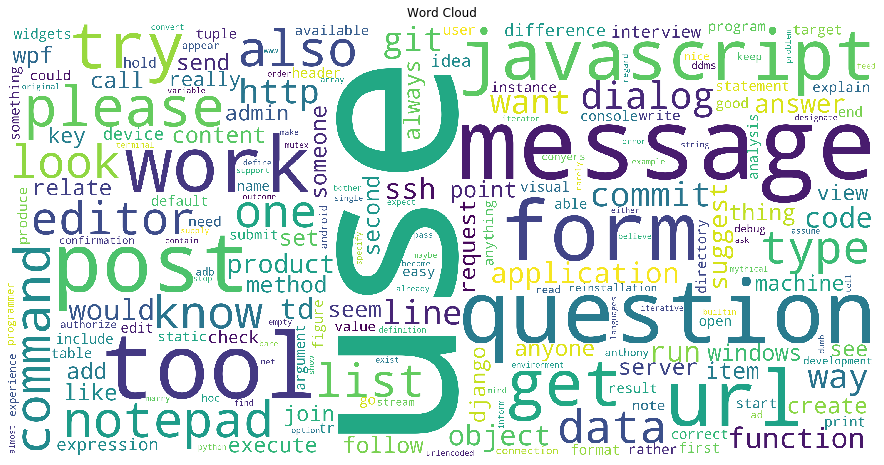

In [17]:
#Word Cloud
clean_test.word_cloud()

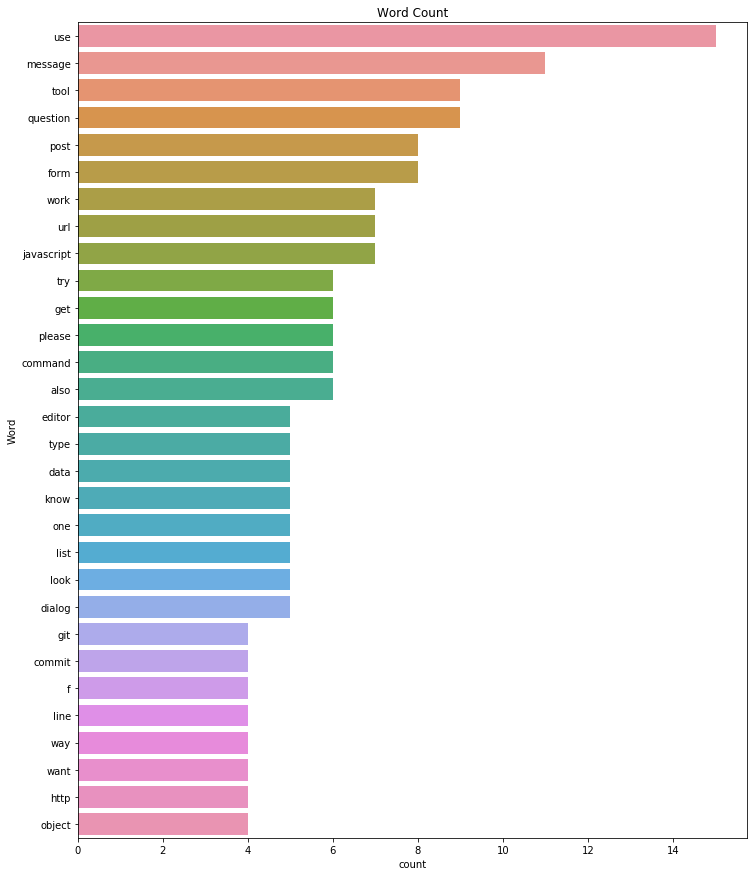

In [18]:
#Word Count
clean_test.word_count()

### 2.2 Analyse, cleansing et sélection de "Tags"<a class="anchor" id="2.2"></a>

In [19]:
display(df["Tags"].head(20))

0     <windows><git><cygwin><editor>                    
1     <language-agnostic><expression><language-features>
2     <angularjs><post><angular-http>                   
3     <c#><.net><wpf><mutex>                            
4     <python><object><iterator>                        
5     <python><list><matrix><transpose>                 
6     <javascript><compression>                         
7     <frameworks><mapreduce><glossary>                 
8     <bash><ssh><csh>                                  
9     <c#><events><delegates><glossary>                 
10    <sql><database><join><inner-join><outer-join>     
11    <c><printf><long-integer>                         
12    <python><django>                                  
13    <c#><code-analysis><static-analysis>              
14    <wpf>                                             
15    <android><usb><adb><device><unauthorized>         
16    <java><java-8><java-stream>                       
17    <vim><plugins>           

In [20]:
#Appel de la classe
clean_tags = cleansing(df, 'Tags')

In [21]:
#On commence par passer les tags en minuscule et retirer les stop words
clean_tags.lower_case()
clean_tags.token()

In [22]:
all_words = ' '.join(v for v in df['Tags'])
all_words = all_words.split() 
fdist = nltk.FreqDist(all_words)

In [23]:
len(fdist.keys())

5127

In [24]:
display(fdist)

FreqDist({'android': 2738, 'python': 2238, 'javascript': 2216, 'java': 1935, 'git': 1717, 'net': 1226, 'c#': 1144, 'c++': 1133, 'ios': 1063, 'c': 1048, ...})

In [25]:
newDict = {key: value for (key, value) in fdist.items() if value < 300 }

In [26]:
len(newDict)

5090

In [27]:
#On liste les tags que nous souhaitons supprimer
list_tags_to_del = list(newDict.keys())
print (list_tags_to_del)

['cygwin', 'editor', 'language', 'agnostic', 'expression', 'features', 'post', 'angular', 'http', 'wpf', 'mutex', 'object', 'iterator', 'list', 'matrix', 'transpose', 'compression', 'frameworks', 'mapreduce', 'glossary', 'ssh', 'csh', 'events', 'delegates', 'join', 'inner', 'outer', 'printf', 'long', 'integer', 'django', 'code', 'analysis', 'static', 'usb', 'adb', 'device', 'unauthorized', 'stream', 'vim', 'plugins', 'mp', 'id', 'automation', 'scp', 'command', 'line', 'migration', 'south', 'design', 'patterns', 'principles', 'undo', 'pull', 'ggplot', 'gridextra', 'search', 'sqlite', 'sed', 'grep', 'clojure', 'intellij', 'idea', 'accounting', 'npm', 'merge', 'domain', 'driven', 'push', 'notification', 'mqtt', 'ng', 'model', 'fileupload', 'express', 'fs', 'turing', 'complete', 'activity', 'tabhost', 'mime', 'types', 'directory', 'copy', 'debugging', 'gdb', 'breakpoints', 'memory', 'access', 'gcc', 'makefile', 'verbosity', 'pandas', 'batch', 'working', 'verification', 'ipa', 'man', 'in', 

In [28]:
#On créé une nouvelle variable contenant les tags restants par observation
df['new_tags'] = [' '.join([y for y in x.split() if y not in list_tags_to_del]) for x in df['Tags']]

In [29]:
df.head()

,Id,Title,Body,Tags,token_Tags,new_tags
0,10564,How can I set up an editor to work with Git on Windows?,"<p>I'm trying out <strong>Git on Windows</strong>. I got to the point of trying ""git commit"" and I got this error:</p>\n\n<blockquote>\n <p>Terminal is dumb but no VISUAL nor\n EDITOR defined. Please supply the\n message using either -m or -F option.</p>\n</blockquote>\n\n<p>So I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got <a href=""http://notepad-plus.sourceforge.net/uk/site.htm"" rel=""noreferrer"">Notepad++</a>, but I can't figure out how to get Notepad++ set up as the <code>%EDITOR%</code> in such a way that it works with Git as expected.</p>\n\n<p>I'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to <strong>type commit messages in an editor</strong> rather than the command line (with <code>-m</code>).</p>\n\n<p>Those of you using Git on Windows: What tool do you use to edit your commit messages, and what did you have to do to make it work?</p>\n",windows git cygwin editor,"[windows, git, cygwin, editor]",windows git
1,19132,Expression Versus Statement,"<p>I'm asking with regards to c#, but I assume its the same in most other languages.</p>\n\n<p>Does anyone have a good definition of <em>expressions</em> and <em>statements</em> and what the differences are?</p>\n",language agnostic expression language features,"[language, agnostic, expression, language, features]",
2,19254029,AngularJs $http.post() does not send data,"<p>Could anyone tell me why the following statement does not send the post data to the designated url? The url is called but on the server when I print $_POST - I get an empty array. If I print message in the console before adding it to the data - it shows the correct content.</p>\n\n<pre><code>$http.post('request-url', { 'message' : message });\n</code></pre>\n\n<p>I've also tried it with the data as string (with the same outcome):</p>\n\n<pre><code>$http.post('request-url', ""message="" + message);\n</code></pre>\n\n<p>It seem to be working when I use it in the following format:</p>\n\n<pre><code>$http({\n method: 'POST',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'Content-Type': 'application/x-www-form-urlencoded'}\n});\n</code></pre>\n\n<p>but is there a way of doing it with the $http.post() - and do I always have to include the header in order for it to work? I believe that the above content type is specifying format of the sent data, but can I send it as javascript object?</p>\n",angularjs post angular http,"[angularjs, post, angular, http]",angularjs
3,19147,What is the correct way to create a single-instance WPF application?,"<p>Using C# and WPF under .NET (rather than <a href=""http://en.wikipedia.org/wiki/Windows_Forms"" rel=""noreferrer"">Windows Forms</a> or console), what is the correct way to create an application that can only be run as a single instance?</p>\n\n<p>I know it has something to do with some mythical thing called a mutex, rarely can I find someone that bothers to stop and explain what one of these are.</p>\n\n<p>The code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.</p>\n",c# net wpf mutex,"[c#, net, wpf, mutex]",c# net
4,19151,Build a Basic Python Iterator,<p>How would one create an iterative function (or iterator object) in python?</p>\n,python object iterator,"[python, object, iterator]",python


In [30]:
#On supprime les lignes sans tags
df = df[df['new_tags']!='']

df.shape

(16926, 6)

In [31]:
df['count_tags'] = df['new_tags'].str.split().apply(len)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
df = df[df['count_tags']<=3]
print(df.shape)

(15884, 7)


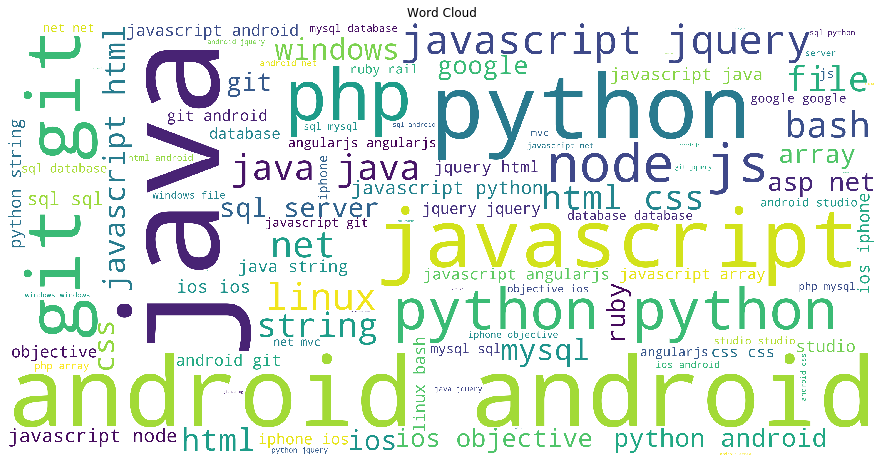

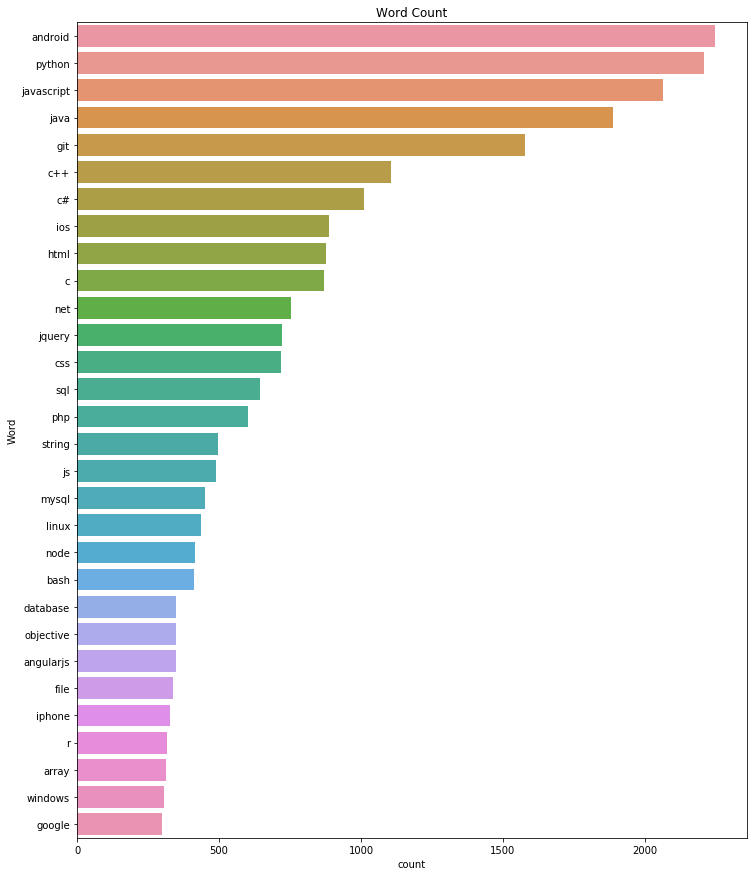

,Id,Title,Body,Tags,token_Tags,new_tags,count_tags,token_new_tags,lem_token_new_tags,stem_lem_token_new_tags
0,10564,How can I set up an editor to work with Git on Windows?,"<p>I'm trying out <strong>Git on Windows</strong>. I got to the point of trying ""git commit"" and I got this error:</p>\n\n<blockquote>\n <p>Terminal is dumb but no VISUAL nor\n EDITOR defined. Please supply the\n message using either -m or -F option.</p>\n</blockquote>\n\n<p>So I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got <a href=""http://notepad-plus.sourceforge.net/uk/site.htm"" rel=""noreferrer"">Notepad++</a>, but I can't figure out how to get Notepad++ set up as the <code>%EDITOR%</code> in such a way that it works with Git as expected.</p>\n\n<p>I'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to <strong>type commit messages in an editor</strong> rather than the command line (with <code>-m</code>).</p>\n\n<p>Those of you using Git on Windows: What tool do you use to edit your commit messages, and what did you have to do to make it work?</p>\n",windows git cygwin editor,"[windows, git, cygwin, editor]",windows git,2,"[windows, git]","[windows, git]","[window, git]"
2,19254029,AngularJs $http.post() does not send data,"<p>Could anyone tell me why the following statement does not send the post data to the designated url? The url is called but on the server when I print $_POST - I get an empty array. If I print message in the console before adding it to the data - it shows the correct content.</p>\n\n<pre><code>$http.post('request-url', { 'message' : message });\n</code></pre>\n\n<p>I've also tried it with the data as string (with the same outcome):</p>\n\n<pre><code>$http.post('request-url', ""message="" + message);\n</code></pre>\n\n<p>It seem to be working when I use it in the following format:</p>\n\n<pre><code>$http({\n method: 'POST',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'Content-Type': 'application/x-www-form-urlencoded'}\n});\n</code></pre>\n\n<p>but is there a way of doing it with the $http.post() - and do I always have to include the header in order for it to work? I believe that the above content type is specifying format of the sent data, but can I send it as javascript object?</p>\n",angularjs post angular http,"[angularjs, post, angular, http]",angularjs,1,[angularjs],[angularjs],[angularj]
3,19147,What is the correct way to create a single-instance WPF application?,"<p>Using C# and WPF under .NET (rather than <a href=""http://en.wikipedia.org/wiki/Windows_Forms"" rel=""noreferrer"">Windows Forms</a> or console), what is the correct way to create an application that can only be run as a single instance?</p>\n\n<p>I know it has something to do with some mythical thing called a mutex, rarely can I find someone that bothers to stop and explain what one of these are.</p>\n\n<p>The code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.</p>\n",c# net wpf mutex,"[c#, net, wpf, mutex]",c# net,2,"[c#, net]","[c#, net]","[c#, net]"
4,19151,Build a Basic Python Iterator,<p>How would one create an iterative function (or iterator object) in python?</p>\n,python object iterator,"[python, object, iterator]",python,1,[python],[python],[python]
5,19339,Transpose/Unzip Function (inverse of zip)?,"<p>I have a list of 2-item tuples and I'd like to convert them to 2 lists where the first contains the first item in each tuple and the second list holds the second item.</p>\n\n<p><strong>For example:</strong></p>\n\n<pre><code>original = [('a', 1), ('b', 2), ('c', 3), ('d', 4)]\n# and I want to become...\nresult = (['a', 'b', 'c', 'd'], [1, 2, 3, 4])\n</code></pre>\n\n<p>Is there a builtin

In [33]:
clean_tags = cleansing(df, 'new_tags')

clean_tags.token()
clean_tags.rm_stopwords()
clean_tags.lem()
clean_tags.stem()
clean_tags.word_cloud()
clean_tags.word_count()

#Vérification
display(df.head(20))

### 2.3 Analyse et cleansing de "Title"<a class="anchor" id="2.3"></a>

<p>Passons à présent à l'analyse du champs "Title" sur ce jeu de données légèrement réduit après l'analyse des tags. 

In [34]:
display(df["Title"].head(20))

0     How can I set up an editor to work with Git on Windows?                                            
2     AngularJs $http.post() does not send data                                                          
3     What is the correct way to create a single-instance WPF application?                               
4     Build a Basic Python Iterator                                                                      
5     Transpose/Unzip Function (inverse of zip)?                                                         
6     Best JavaScript compressor                                                                         
8     Getting ssh to execute a command in the background on target machine                               
9     What are the differences between delegates and events?                                             
10    What is the difference between "INNER JOIN" and "OUTER JOIN"?                                      
11    What is the argument for printf that for

In [35]:
#Appel de la classe
clean_title = cleansing(df, 'Title')

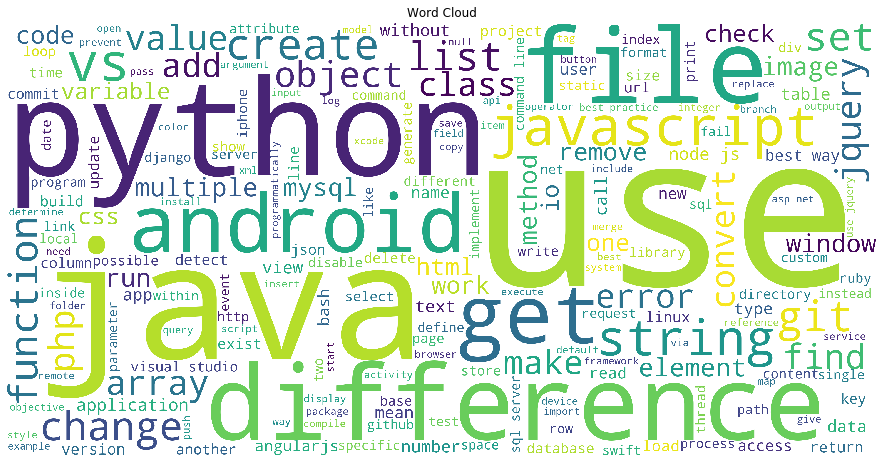

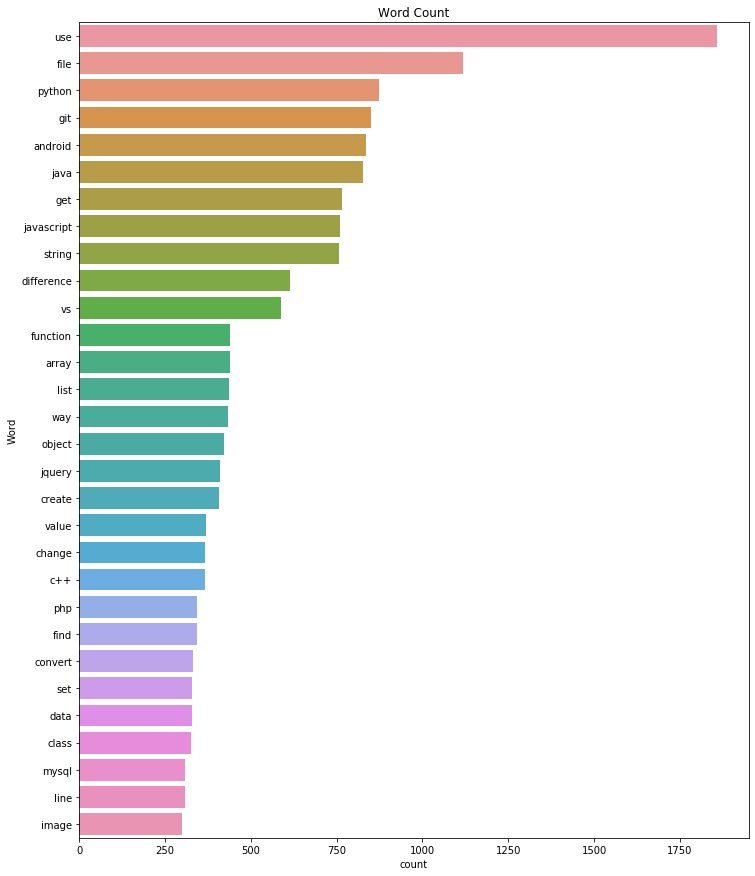

,Id,Title,Body,Tags,token_Tags,new_tags,count_tags,token_new_tags,lem_token_new_tags,stem_lem_token_new_tags,token_Title,lem_token_Title,stem_lem_token_Title
0,10564,how can i set up an editor to work with git on windows,"<p>I'm trying out <strong>Git on Windows</strong>. I got to the point of trying ""git commit"" and I got this error:</p>\n\n<blockquote>\n <p>Terminal is dumb but no VISUAL nor\n EDITOR defined. Please supply the\n message using either -m or -F option.</p>\n</blockquote>\n\n<p>So I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got <a href=""http://notepad-plus.sourceforge.net/uk/site.htm"" rel=""noreferrer"">Notepad++</a>, but I can't figure out how to get Notepad++ set up as the <code>%EDITOR%</code> in such a way that it works with Git as expected.</p>\n\n<p>I'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to <strong>type commit messages in an editor</strong> rather than the command line (with <code>-m</code>).</p>\n\n<p>Those of you using Git on Windows: What tool do you use to edit your commit messages, and what did you have to do to make it work?</p>\n",windows git cygwin editor,"[windows, git, cygwin, editor]",windows git,2,"[windows, git]","[windows, git]","[window, git]","[set, editor, work, git, windows]","[set, editor, work, git, windows]","[set, editor, work, git, window]"
2,19254029,angularjs http post does not send data,"<p>Could anyone tell me why the following statement does not send the post data to the designated url? The url is called but on the server when I print $_POST - I get an empty array. If I print message in the console before adding it to the data - it shows the correct content.</p>\n\n<pre><code>$http.post('request-url', { 'message' : message });\n</code></pre>\n\n<p>I've also tried it with the data as string (with the same outcome):</p>\n\n<pre><code>$http.post('request-url', ""message="" + message);\n</code></pre>\n\n<p>It seem to be working when I use it in the following format:</p>\n\n<pre><code>$http({\n method: 'POST',\n url: 'request-url',\n data: ""message="" + message,\n headers: {'Content-Type': 'application/x-www-form-urlencoded'}\n});\n</code></pre>\n\n<p>but is there a way of doing it with the $http.post() - and do I always have to include the header in order for it to work? I believe that the above content type is specifying format of the sent data, but can I send it as javascript object?</p>\n",angularjs post angular http,"[angularjs, post, angular, http]",angularjs,1,[angularjs],[angularjs],[angularj],"[angularjs, http, post, send, data]","[angularjs, http, post, send, data]","[angularj, http, post, send, data]"
3,19147,what is the correct way to create a single instance wpf application,"<p>Using C# and WPF under .NET (rather than <a href=""http://en.wikipedia.org/wiki/Windows_Forms"" rel=""noreferrer"">Windows Forms</a> or console), what is the correct way to create an application that can only be run as a single instance?</p>\n\n<p>I know it has something to do with some mythical thing called a mutex, rarely can I find someone that bothers to stop and explain what one of these are.</p>\n\n<p>The code needs to also inform the already-running instance that the user tried to start a second one, and maybe also pass any command-line arguments if any existed.</p>\n",c# net wpf mutex,"[c#, net, wpf, mutex]",c# net,2,"[c#, net]","[c#, net]","[c#, net]","[correct, way, create, single, instance, wpf, application]","[correct, way, create, single, instance, wpf, application]","[correct, way, creat, singl, instanc, wpf, applic]"
4,19151,build a basic python iterator,<p>How would one create an iterative function (or iterator object) in python?</p>\n,python object iterator,"[python, object, iterator]",python,1,[python],[python],[python],"[build

In [36]:
#Lancement des fonctions
clean_title.lower_case()
clean_title.token()
clean_title.rm_stopwords()
clean_title.lem()
clean_title.stem()

clean_title.word_cloud()
clean_title.word_count()

#Vérification
display(df.head(20))

### 2.4 Analyse et cleansing de "Body"<a class="anchor" id="2.4"></a>

In [37]:
display(df["Body"].head(20))

0     <p>I'm trying out <strong>Git on Windows</strong>. I got to the point of trying "git commit" and I got this error:</p>\n\n<blockquote>\n  <p>Terminal is dumb but no VISUAL nor\n  EDITOR defined. Please supply the\n  message using either -m or -F option.</p>\n</blockquote>\n\n<p>So I figured out I need to have an environment variable called EDITOR. No problem. I set it to point to Notepad. That worked, almost. The default commit message opens in Notepad. But Notepad doesn't support bare line feeds. I went out and got <a href="http://notepad-plus.sourceforge.net/uk/site.htm" rel="noreferrer">Notepad++</a>, but I can't figure out how to get Notepad++ set up as the <code>%EDITOR%</code> in such a way that it works with Git as expected.</p>\n\n<p>I'm not married to Notepad++. At this point I don't mind what editor I use. I just want to be able to <strong>type commit messages in an editor</strong> rather than the command line (with <code>-m</code>).</p>\n\n<p>Those of you using Git on 

In [38]:
#Appel de la classe
clean_body = cleansing(df, 'Body')

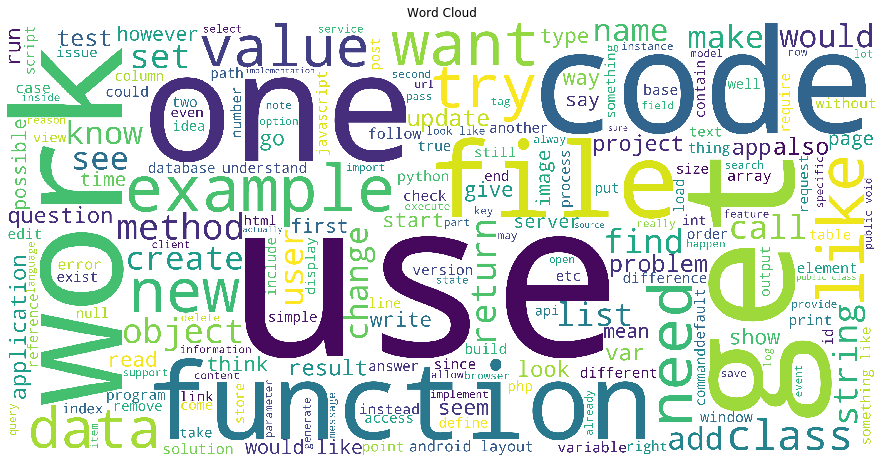

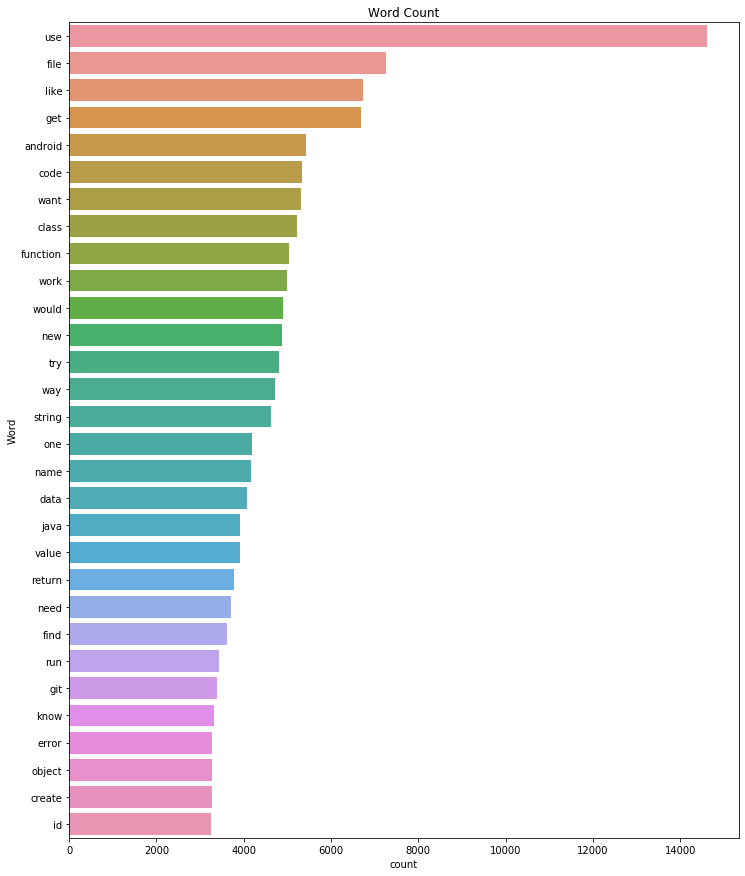

,Id,Title,Body,Tags,token_Tags,new_tags,count_tags,token_new_tags,lem_token_new_tags,stem_lem_token_new_tags,token_Title,lem_token_Title,stem_lem_token_Title,token_Body,lem_token_Body,stem_lem_token_Body
0,10564,how can i set up an editor to work with git on windows,i m trying out git on windows i got to the point of trying git commit and i got this error terminal is dumb but no visual nor editor defined please supply the message using either m or f option so i figured out i need to have an environment variable called editor no problem i set it to point to notepad that worked almost the default commit message opens in notepad but notepad doesn t support bare line feeds i went out and got notepad++ but i can t figure out how to get notepad++ set up as the editor in such a way that it works with git as expected i m not married to notepad++ at this point i don t mind what editor i use i just want to be able to type commit messages in an editor rather than the command line with m those of you using git on windows what tool do you use to edit your commit messages and what did you have to do to make it work,windows git cygwin editor,"[windows, git, cygwin, editor]",windows git,2,"[windows, git]","[windows, git]","[window, git]","[set, editor, work, git, windows]","[set, editor, work, git, windows]","[set, editor, work, git, window]","[trying, git, windows, got, point, trying, git, commit, got, error, terminal, dumb, visual, editor, defined, please, supply, message, using, either, f, option, figured, need, environment, variable, called, editor, problem, set, point, notepad, worked, almost, default, commit, message, opens, notepad, notepad, support, bare, line, feeds, went, got, notepad++, figure, get, notepad++, set, editor, way, works, git, expected, married, notepad++, point, mind, editor, use, want, able, type, commit, messages, editor, rather, command, line, using, git, windows, tool, use, edit, commit, messages, make, work]","[try, git, windows, get, point, try, git, commit, get, error, terminal, dumb, visual, editor, define, please, supply, message, use, either, f, option, figure, need, environment, variable, call, editor, problem, set, point, notepad, work, almost, default, commit, message, open, notepad, notepad, support, bare, line, feed, go, get, notepad++, figure, get, notepad++, set, editor, way, work, git, expect, marry, notepad++, point, mind, editor, use, want, able, type, commit, message, editor, rather, command, line, use, git, windows, tool, use, edit, commit, message, make, work]","[tri, git, window, get, point, tri, git, commit, get, error, termin, dumb, visual, editor, defin, pleas, suppli, messag, use, either, f, option, figur, need, environ, variabl, call, editor, problem, set, point, notepad, work, almost, default, commit, messag, open, notepad, notepad, support, bare, line, feed, go, get, notepad++, figur, get, notepad++, set, editor, way, work, git, expect, marri, notepad++, point, mind, editor, use, want, abl, type, commit, messag, editor, rather, command, line, use, git, window, tool, use, edit, commit, messag, make, work]"
2,19254029,angularjs http post does not send data,could anyone tell me why the following statement does not send the post data to the designated url the url is called but on the server when i print post i get an empty array if i print message in the console before adding it to the data it shows the correct content http post request url message message i ve also tried it with the data as string with the same outcome http post request url message + message it seem to be working when i use it in the following format http method post url request url data message + message headers content type application x www form urlencoded but is there a way of doing it with the http post and do i always have to include the header in order for it to work i believe that the above content type is specifying format of the sent data but can i send it as javascript object,angularjs post angular http,"[angular

In [39]:
#Lancement des fonctions
clean_body.html_parse()
clean_body.lower_case()
clean_body.token()
clean_body.rm_stopwords()
clean_body.lem()
clean_body.stem()
clean_body.word_cloud()
clean_body.word_count()

#Vérification
display(df.head(20))

### 2.5 Suppression des mots peu fréquents<a class="anchor" id="2.5"></a>

In [40]:
#Fusion du titre et du body
df['Title_Body'] = df['lem_token_Title']+df['lem_token_Body']

In [41]:
corpus = ' '.join(str(v) for v in df['Title_Body'])

char = ["'", "[", "]",","]
for text in char:
    corpus = corpus.replace(text, '')
    
all_words = corpus.split()
dictionary = {}
for word in all_words:
    if word in dictionary:
        dictionary[word] += 1
    else:
        dictionary[word] = 1

In [42]:
dictionary_sort = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=False)}

In [43]:
words_to_keep = [k for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True) if v > 2]

In [44]:
len(words_to_keep)

16034

In [45]:
df['Title_Body'] = df['Title_Body'].apply(lambda x: [item for item in x if item in words_to_keep])

## Export des datas<a class="anchor" id="3"></a>

In [46]:
#Extraction des colonnes à exporter
df_export = df[['Title_Body','lem_token_new_tags']]
df_export.rename(columns={"lem_token_new_tags": "Tags"},inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
df_export.head()

,Title_Body,Tags
0,"[set, editor, work, git, windows, try, git, windows, get, point, try, git, commit, get, error, terminal, dumb, visual, editor, define, please, supply, message, use, either, f, option, figure, need, environment, variable, call, editor, problem, set, point, notepad, work, almost, default, commit, message, open, notepad, notepad, support, bare, line, feed, go, get, notepad++, figure, get, notepad++, set, editor, way, work, git, expect, marry, notepad++, point, mind, editor, use, want, able, type, commit, message, editor, rather, command, line, use, git, windows, tool, use, edit, commit, message, make, work]","[windows, git]"
2,"[angularjs, http, post, send, data, could, anyone, tell, follow, statement, send, post, data, designate, url, url, call, server, print, post, get, empty, array, print, message, console, add, data, show, correct, content, http, post, request, url, message, message, also, try, data, string, outcome, http, post, request, url, message, +, message, seem, work, use, follow, format, http, method, post, url, request, url, data, message, +, message, headers, content, type, application, x, www, form, urlencoded, way, http, post, always, include, header, order, work, believe, content, type, specify, format, send, data, send, javascript, object]",[angularjs]
3,"[correct, way, create, single, instance, wpf, application, use, c#, wpf, net, rather, windows, form, console, correct, way, create, application, run, single, instance, know, something, thing, call, mutex, rarely, find, someone, bother, stop, explain, one, code, need, also, inform, already, run, instance, user, try, start, second, one, maybe, also, pass, command, line, arguments, exist]","[c#, net]"
4,"[build, basic, python, iterator, would, one, create, function, iterator, object, python]",[python]
5,"[transpose, unzip, function, inverse, zip, list, item, tuples, like, convert, list, first, contain, first, item, tuple, second, list, hold, second, item, example, original, b, c, #, want, become, result, b, c, builtin, function]",[python]


In [48]:
#export du fichier
df_export.to_csv('export.csv', index=False)